In [56]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input

from keras.utils import to_categorical


In [57]:
def convertImg(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img


In [58]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " " * \
        round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end="\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" %
              (progr, val+1, folder), end="\r")


In [59]:
dataset_folder = "dataset/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))
    for i, name in enumerate(files):
        if name.find(".jpg") > -1 or name.find(".jpeg") > -1 or name.find(".png") > -1:
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = convertImg(img)
            if img is not None:
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)



[####################] (44 samples)	 label : Yaumil 		
[####################] (49 samples)	 label : Asnan 		
[################### ] (38 samples)	 label : Bayu 		
[####################] (47 samples)	 label : Akbar 		


In [60]:
print("number of samples :", len(names))


number of samples : 228


In [61]:
import glob

In [62]:
# # fig = plt.figure(figsize=(2, 1))
# normal_images = []
# for img_path in glob.glob(dataset_folder + '/normal/*'):
#     normal_images.append(mpimg.imread(img_path))

# covid_images = []
# for img_path in glob.glob(dataset_folder + '/covid/*'):
#     covid_images.append(mpimg.imread(img_path))
    
# fig = plt.figure()
# fig.suptitle('normal')
# plt.imshow(normal_images[0], cmap='gray')

# fig = plt.figure()
# fig.suptitle('covid')
# plt.imshow(covid_images[0], cmap='gray')


In [63]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])

    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h),
                borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_10,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_3,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_6,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6,
                (w, h), borderValue=(255, 255, 255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30))
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))

    return imgs


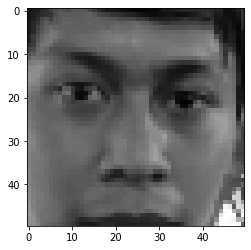

In [64]:
plt.imshow(images[0], cmap="gray")


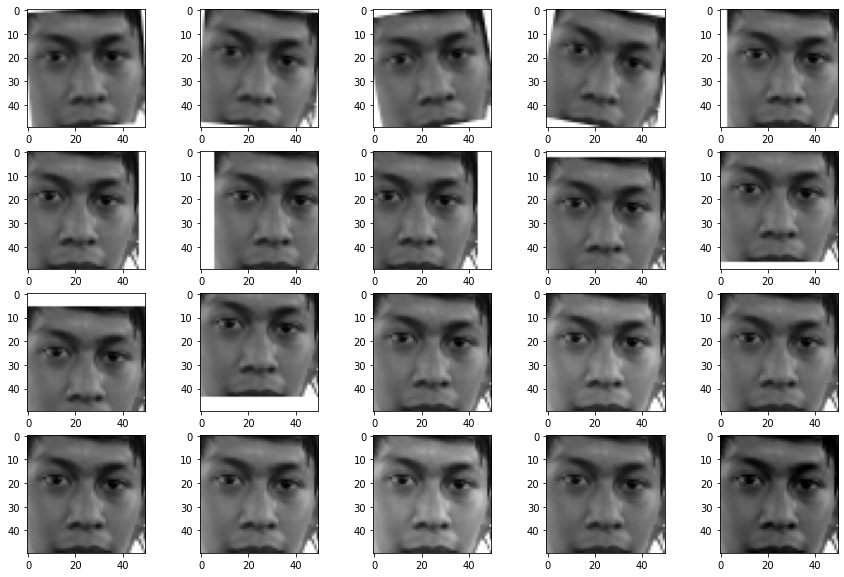

In [65]:
img_test = images[0]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15, 10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap="gray")
plt.show()


In [66]:
unique, counts = np.unique(names, return_counts=True)

for item in zip(unique, counts):
    print(item)


('Akbar', 47)
('Asnan', 49)
('Azis', 50)
('Bayu', 38)
('Yaumil', 44)


In [67]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try:
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except:
        print(i)

print("Total Augmented Images :", len(augmented_images), len(augmented_names))


Total Augmented Images : 4560 4560


In [68]:
images.extend(augmented_images)
names.extend(augmented_names)
unique, counts = np.unique(names, return_counts=True)

print("Total Augmented Images + Original :", len(images), len(names))

for item in zip(unique, counts):
    print(item)


Total Augmented Images + Original : 4788 4788
('Akbar', 987)
('Asnan', 1029)
('Azis', 1050)
('Bayu', 798)
('Yaumil', 924)


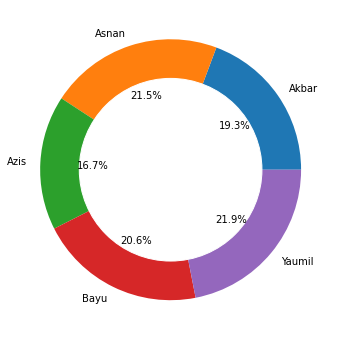

In [69]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(12, 6))

    my_circle = plt.Circle((0, 0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()


unique = np.unique(names)
label_distr = {i: names.count(i) for i in names}.values()
print_data(label_distr, unique)


In [70]:
# reduce sample size per-class using numpy random choice
n = 500


def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)


mask = np.hstack([randc(names, l) for l in np.unique(names)])


In [71]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]


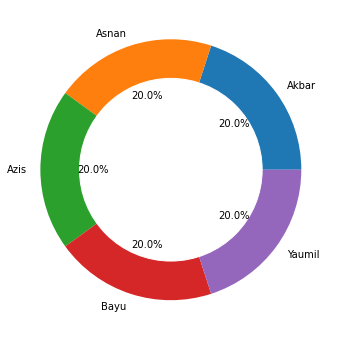

In [72]:
label_distr = {i: names.count(i) for i in names}.values()
print_data(label_distr, unique)


In [73]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)


### 1.2 Encoding Label & Categoricalization


In [74]:
print("number of class :", len(labels))
print(labels)


number of class : 5
['Akbar' 'Asnan' 'Azis' 'Bayu' 'Yaumil']


In [75]:
print(name_vec)


[0 0 0 ... 4 4 4]


In [76]:
print(categorical_name_vec)


[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


### 1.3 Split Dataset

In [77]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    # target/output data
                                                    np.array(
                                                        categorical_name_vec),
                                                    test_size=0.3,
                                                    random_state=42)


In [78]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)


(1750, 50, 50) (1750, 5) (750, 50, 50) (750, 5)


### 1.4 Reshape Data

In [79]:
x_train = x_train.reshape(
    x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)


In [80]:
x_train.shape, x_test.shape


((1750, 50, 50, 1), (750, 50, 50, 1))

### 1.4 Create CNN Model

In [81]:
from keras.layers import Conv2D, MaxPool2D, Flatten


In [82]:
def cnn_model(input_shape):  
    model = Sequential()

    model.add(Conv2D(64,
                     (3, 3),
                     padding="valid",
                     activation="relu",
                     input_shape=input_shape))
    model.add(Conv2D(64,
                     (3, 3),
                     padding="valid",
                     activation="relu",
                     input_shape=input_shape))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128,
                     (3, 3),
                     padding="valid",
                     activation="relu"))
    model.add(Conv2D(128,
                     (3, 3),
                     padding="valid",
                     activation="relu"))

    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128,
                     (3, 3),
                     padding="valid",
                     activation="relu"))

    model.add(Conv2D(128,
                     (3, 3),
                     padding="valid",
                     activation="relu"))

    model.add(Flatten())

    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    # model.add(Dense(16, activation="relu"))
    model.add(Dense(len(labels)))
    model.add(Activation("softmax"))

    model.summary()

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [83]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                  

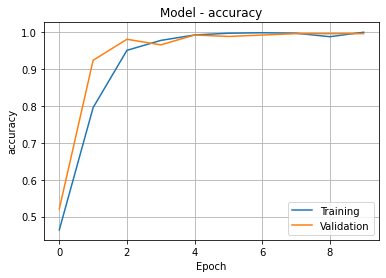

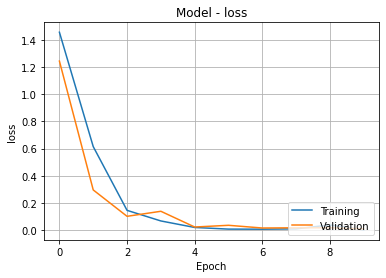

In [84]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'],
             ['loss', 'val_loss']]
    for name in names:
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()


evaluate_model_(history)


In [85]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [86]:
ypred = model.predict(x_test)


24/24 [==============================] - 1s 31ms/step


In [87]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()


In [88]:
print('Accuracy of the Model is',(accuracy_score(ytrue, ypred))*100)

Accuracy of the Model is 99.73333333333333


In [1]:
model.save("../output/trained-model.h5")

In [90]:
np.save("../output/labels.npy", labels)
